In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import root, fmin

fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

## Model

We consider a DC squid with one weak link (phase difference $\phi$) and one conventional junction (phase difference $\varphi-\phi$, with $\varphi$ the flux through the squid in units of the superconducting flux quantum):

![caption](squid.png)

Josephson energy of the weak link:

$$
- E_A \sqrt{1-T \sin^2[(\varphi-\phi)/2]}
$$

with $T$ the transmission coefficient through the junction. Josephson energy of the tunnel junction:

$$
E_J [1-\cos(\phi)]
$$

Total Josephson energy in the ground state of the junction (no excited Andreev pairs):

$$
E_\textrm{tot}(\phi, \varphi) = E_J [1-\cos(\phi)] - E_A \sqrt{1-T \sin^2[(\varphi-\phi)/2]}
$$

Ignoring charging energy (for the moment), the ground state energy is obtained by minimizing $E_\textrm{tot}$ over $\phi$. Current through the weak link:

$$
I_A = \frac{2e}{\hbar}\,\frac{E_A T}{4}\,\frac{\sin (\varphi-\phi)}{\sqrt{1-T \sin^2[(\varphi-\phi)/2]}}
$$

Current through the tunnel junction:

$$
I_J = \frac{2e}{\hbar}\,E_J \sin \phi
$$

Note that the signs of $I_A$ and $I_J$ are both defined to be positive with respect to the counterclockwise [$\circlearrowleft$] direction in the SQUID. If an external transport current $I_\textrm{ext}$ is passed through the junction (via a branch not shown in the figure above), then Kirchoff's rule gives $I_\textrm{ext}=I_J  - I_A$. The critical current of the SQUID is indeed given by

$$
I_c(\varphi) = \frac{2e}{\hbar}\max_\phi \partial_\phi E_\textrm{tot}(\phi, \varphi) = \frac{2e}{\hbar}\max_\phi\,\bigg[ E_J \sin\phi - E_A \frac{\sin (\varphi-\phi)}{\sqrt{1-T \sin^2[(\varphi-\phi)/2]}}\bigg]
$$

### Model for the weak link in presence of charging energy

If there is a charging energy and if one takes into account the possibility to excite a pair of electrons into the Andreev bound state, the Hamiltonian of the circuit is

$$H = E_C\,\sigma_0\,\hat{N}^2 + V(\hat{\phi})$$

where the potential energy is (taken from [this paper from Saclay](http://arxiv.org/pdf/1406.6301.pdf), actually derived in [this paper](http://arxiv.org/pdf/cond-mat/0206342.pdf) and [this paper](http://arxiv.org/pdf/cond-mat/0404656.pdf) by Zazunov, Shumeiko et al.)

$$
V(\hat\phi)=E_J\,\sigma_0\,[1-\cos(\varphi-\hat\phi)] + E_A\sigma_3\,V_3(\hat\phi) + E_A\,\sigma_2\,V_2(\hat\phi)\\
V_3(\hat\phi)=\cos\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}+\sqrt{R}\,\sin\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}\\
V_2(\hat\phi)=\sqrt{R}\,\cos\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}-\sin\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}
$$

Here $\sigma_0, \sigma_2, \sigma_3$ are Pauli matrices which distinguish the ground state from the state with an excited pair in the junction. $R=1-T$ is the reflection coefficient of the junction.

For very small charging energy, one may find the following expression for the plasma frequency at zero flux by expanding $V(\hat{\phi})$ around $\phi = 0$ and diagonalizing the $\sigma$ part. The result is

$$\hbar\omega_p = \sqrt{2 E_C\,(E_J + E_A T/4)}$$

This equation may be used to estimate the charging energy from the experimentally observed plasma frequency.

## Parameters for 30 nm device [CHECK!!]

Let me estimate the parameters of the model for the device with the 30 nm short junction.

From slide 35 of Attila's talk, I extract $E_A\approx 70\,\mu$eV (note that I think there is a factor of 2 off quoted in the slide) and $T=0.54$.

From David's table, I take the critical current of the tunnel junction $\max I_J=42.5 nA$. Via the relation $I = 2e E_J/\hbar$, this gives $E_J = 87\;\mu$eV.

Also from David's table, the plasma frequency for this device is estimated to be $\omega_p = 16.5$ GHz. From this relation one may extract $E_c$.

Converting everything to GHZ, I find:

$E_J \approx (1/\hbar) \times 87\;µ$ eV $\approx 132.1$ GHz.

$E_A \approx (1/\hbar) \times 70\;µ$ eV $\approx 106.5$ GHz.

$E_c \approx \omega_p^2/(2E_J + E_A T / 4) \approx 0.97$ GHz. 

In [2]:
p = SimpleNamespace(Ej = 132.1, Ec=0.97, Ea=106.5, T=0.54)

## Finding phase drop across the weak link

Ignoring charging energy for a moment, one may ask what is the phase $\phi$ which determines the phase drop across the weak link, as a function of the applied flux.

To answer this question, we seek to minimize the energy with respect to the phase at fixed flux. To find $\phi_0$ we must solve the following transcendental equation

\begin{equation}
E_J\sin(\phi_0)-\frac{E_A \,T\,\sin(\varphi-\phi_0)}{4\,\sqrt{1-T \sin^2[(\varphi-\phi_0)/2]}}=0 
\end{equation}

Clearly, when $E_J\gg E_A T/4$ the solution is given with good approximation by $\phi \approx 0$. Expanding the transcendental equation to first order in $\phi_0$, one finds the following approximate solution:

\begin{equation}
\phi_0\approx \frac{E_A T}{E_J}\,\frac{\sin\varphi}{\sqrt{1-T\sin^2\varphi/2}} + O[(E_AT/E_J)^2]\,.
\end{equation}

Alternativcely, the solution can also be found numerically. I find that the two methods agree quite well, particularly for not too large transmission $T$.

In [3]:
def jos_energy(x, p):
    return p.Ej * (1 - np.cos(x)) - p.Ea * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2)

def andreev_energy(x, p):
    return - p.Ea * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2)

def phase_derivative_jos_energy(x, p):
    return p.Ej * np.sin(x) - p.Ea * p.T * np.sin(p.flux - x) / (4 * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2))

def andreev_current(x, p):
    return p.Ea * p.T * np.sin(p.flux - x) / (4 * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2))

In [4]:
fluxes = np.linspace(0, 2*np.pi, 200)
phi0s = []
for flux in fluxes:
    p.flux = flux
    sol = root(phase_derivative_jos_energy, [0.], p)
    phi0s.append(sol.x[0])  

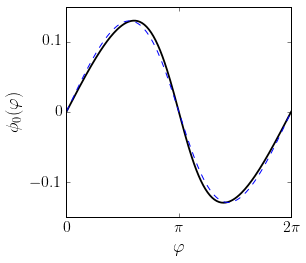

In [6]:
fig, ax = plt.subplots(figsize=(4.6,4))
ax.plot(fluxes, phi0s, 'k', lw = 1.8)
ax.plot(fluxes, -andreev_current(fluxes, p)/p.Ej, 'b--')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_ylim(-0.15, 0.15)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_yticklabels([r'$-0.1$', r'$0$', r'$0.1$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\phi_0(\varphi)$')
fig.show()

Here is the solution for the phase $\phi_0$ as a function of $\phi$. The black one is the numerically determined one, the blue one is the analitical approximation. The correction is quite small and has a sine-like shape.

In the the next plot you can see the resulting difference in the dispersion of the Andreev energy, between $E_A(\varphi)$ and $E_A[\phi_0(\varphi)]$.

In [7]:
new_dispersion = []
for flux in fluxes:
    p.flux = flux
    sol = root(phase_derivative_jos_energy, [0.], p)
    new_dispersion.append(andreev_energy(sol.x[0], p))

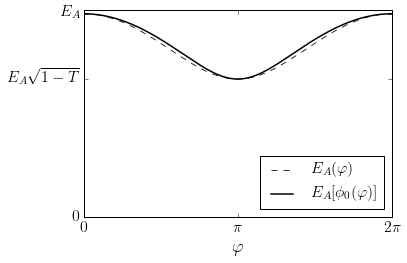

In [8]:
fig, ax = plt.subplots()
ax.plot(fluxes, -np.array(andreev_energy(fluxes, p)), 'k--', lw = 0.8, label = r'$E_A(\varphi)$')
ax.plot(fluxes, -np.array(new_dispersion), 'k', lw=1.5, label = r'$E_A[\phi_0(\varphi)]$')
ax.legend(loc=4)
ax.set_xlim(0, 2*np.pi)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(0, p.Ea + 2)
ax.set_yticks([0, p.Ea, p.Ea * np.sqrt(1-p.T)])
ax.set_yticklabels([r'$0$', r'$E_A$', r'$E_A \sqrt{1-T}$'])

The dashed line is the curve you would have if the phase drop at the weak link was exactly equal to the applied flux. Taking into account for the deviation from this condition results into the black curve. The effect is visible, and would be more marked at stronger transmission.

Perhaps it goes into the opposite direction as what we expected, since 'by eye' the data may look to be 'compressed' around $\varphi=0$. Maybe I have a sign error in $\phi_0$?

## Critical current of the squid

In [9]:
fluxes = np.linspace(0, 2*np.pi, 200)
Ics = []
for flux in fluxes:
    p.flux = flux
    def f(x):
        return - phase_derivative_jos_energy(x, p)
    sol = fmin(f, [np.pi / 2], disp=0)
    Ics.append(-f(sol[0]))

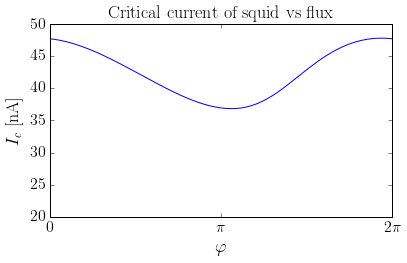

In [10]:
fig, ax = plt.subplots()
ax.plot(fluxes, 0.3204 * np.array(Ics)) # factor of 0.3204 converts GHz to nA
ax.set_xlim(0, 2*np.pi)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(20, 50)
ax.set_ylabel('$I_c$ [nA]')
ax.set_title('Critical current of squid vs flux')

This does not seem to be far off with from what is observed. The skewness is clearly visible.

## Functions which diagonalize the full Hamiltonian, including charging energy

The Hamiltonian is represented in the phase basis, discretizing the $[0, 2\pi)$ with a lattice spacing $2\pi/M$. The integer parameter $M$ is then chosen such that convergence of the eigenvalues is reached (i.e., $M$ is chosen to be at the threshold such that increasing $M$ further does not change the eigenvalues found numerically).

In [11]:
def potential(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return np.cos(0.5 * r * phi) * np.cos(0.5 * phi) + r * np.sin(0.5 * r * phi) * np.sin(0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return r * np.cos(0.5 * r * phi) * np.sin(0.5 * phi) - np.sin(0.5 * r * phi) * np.cos(0.5 * phi)
    elif s == '0':
        return (1 - np.cos(phi))
    else:
        raise ValueError('wrong value of s')
        
def n_me(M, dk):
    x = np.pi * dk / M
    return (-1)**dk  / (np.tan(x) * np.sin(x)) / 2

In [12]:
def create_hamiltonian(p, M, sparse=False):
    # offset diagonal term from charging energy
    h0 = p.Ec * (M**2 - 1) / 12 * np.eye(M) + 0j
    
    # cosine part of the potential
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    h0 += p.Ej * np.diag(np.array([potential(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
     
    #off diagonal parts of the charging energy
    for dk in range(1, M):
        h0 += p.Ec * n_me(M, dk) * (np.eye(M, k=dk) + np.eye(M, k=-dk)) + 0j
    
    # z, y parts of the potential
    hz = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    hy = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    
    h = np.bmat([[h0 + hz, -1j * hy], [1j * hy, h0 - hz]])
    if sparse:
        return sp.coo_matrix(h)
    else:
        return h
    
def find_optimal_M(p, max_tol = 1e-10):
    M = 3
    tol = 100
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.linalg.eigvalsh(H)
    de = ens[1]-ens[0]
    while tol > max_tol:
        M += 4
        H = create_hamiltonian(p, M, sparse=False)
        ens = np.linalg.eigvalsh(H)
        de_new = ens[1]-ens[0]
        tol = np.abs(de_new - de)
        #print M, de, de_new, tol
        de = de_new
    return M

# This function is work in progress - ignore for the moment
def current_matrix_elements_from_gs(p):
    M = find_optimal_M(p)
    H = create_hamiltonian(p, M, sparse=False)
    evals, evec = np.linalg.eigh(H)
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    j0 = np.diag(np.array([np.exp(1j * 2 * np.pi * k / M) for k in ks])) + 0j
    j_op = np.bmat([[j0, np.zeros((M, M))], [np.zeros((M, M)), j0]])
    J = np.abs(np.conj(evec).T.dot(j_op.dot(evec)))
    plt.imshow(np.flipud(J**2), interpolation='none', extent=(0,M,0,M))
    plt.colorbar()
    return np.array(J**2)

#J = current_matrix_elements_from_gs(p)
#plt.plot(J[0][0:], '.')
#plt.ylim(0, 0.1)

## Spectrum and transition frequencies of the 30nm device

In [13]:
M=find_optimal_M(p, max_tol = 1e-10)
fluxes = np.linspace(0, 2*np.pi, 500)
spectra = []
for flux in fluxes:
    p.flux = flux
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:50])
freqs = np.vstack([(s - s[0])[1:] for s in spectra])

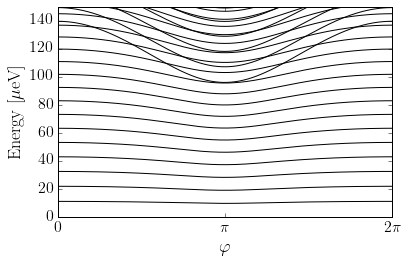

In [14]:
fig, ax = plt.subplots()
for (n, f) in enumerate(freqs.T):
    ax.plot(fluxes, 0.658 * f, c='k') #factor of 0.658 converts GHz to µeV
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(0, 150)
ax.set_ylabel('Energy [$\mu$eV]')
fig.show()

Above you see the energy differences $E_n-E_0$ between the excited states and the ground state of the system. You can see that there are a bunch of weakly dispersing lines between the lowest plasma mode $E_1-E_0$ and the first excited Andreev state with energy $\approx 2 E_A$. These are the states with higher plasma oscillations, and energy $E_n \approx n \omega_p$, $n=2,3,\dots$. That's not surprising that there's so many of them, since we have $\omega_p\ll E_A$ (compare with the Saclay paper, in the plots below, where on the contrary $\omega_p \approx E_A$).

I imagine many of these states cannot be excited from the ground state via the microwaves, hence they are not seen because of that. But this is something to investigate. The same considerations regarding the visibility apply to all those lines with energy $\approx 2E_A + n\omega_p$, $n=1, 2, \dots$.

## A check: Figure from Saclay's paper

In [15]:
p_saclay = SimpleNamespace(Ej = 900, Ea = 43, Ec=0.270, T=0.985, flux=0)

In [16]:
M=find_optimal_M(p_saclay, max_tol = 1e-10)
fluxes = np.linspace(0, 2*np.pi, 500)
spectra = []
for flux in fluxes:
    p_saclay.flux = flux
    H = create_hamiltonian(p_saclay, M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:30])
freqs = np.vstack([(s - s[0])[1:] for s in spectra])

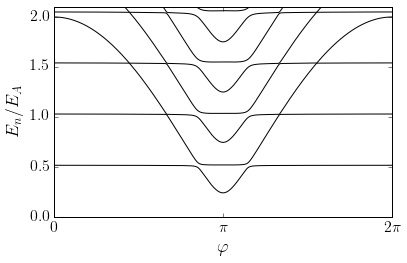

In [17]:
fig, ax = plt.subplots()
for f in freqs.T:
    ax.plot(fluxes, f/p_saclay.Ea, c='k');
ax.set_ylim(0, 2.1)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E_n/E_A$')
fig.show()

This figure should be compared with Fig. 4b of [this paper from Saclay](http://arxiv.org/pdf/1406.6301.pdf). I made it to check that the numerics do give sensible result as well to compare the two devices, which somehow operate in different regimes ($E_A\approx \omega_p$ here, vs $E_A\gg \omega_p$ above).

## Another check: reproducing Fig. 4 of our paper with Gijs

I take comparable parameters, and check if these new numerics would give a similar frequency spectrum.

In [18]:
p_gijs_paper = SimpleNamespace(Ej = 80.84, Ea = 233, Ec=4*0.279, T = 0.885, flux = 0)

In [19]:
M=find_optimal_M(p_gijs_paper, max_tol = 1e-10)
fluxes = np.linspace(np.pi- 0.1, np.pi+0.1, 200)

In [20]:
spectra = []
for flux in fluxes:
    p_gijs_paper.flux = flux
    H = create_hamiltonian(p_gijs_paper, M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:30])

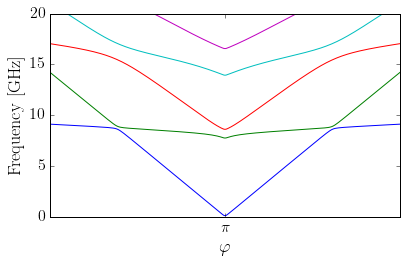

In [21]:
freqs = [(s - s[0])[1:] for s in spectra]
fig, ax = plt.subplots()
ax.plot(fluxes, np.array(freqs));
ax.set_ylim(0, 20)
ax.set_xlim(np.pi - 0.1, np.pi + 0.1)
ax.set_xticks([np.pi])
ax.set_xticklabels([r'$\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel('Frequency [GHz]')
fig.show()

It may have been interesting to see if a similar spectrum would have been observed at low frequencies also in the new devices. The region around zero frequency and phase $\approx \pi$ seems quite crowded in the data, although the data point resolution is very low.